In [1]:
import numpy as np
import pandas as pd

tracks_genres = pd.read_csv('tracks_genres_mio.csv', index_col = 0, header = [0])

In [2]:
import librosa
import sklearn
import librosa.display
from scipy import stats
import os.path

audio_dir = 'C:/Users/bonno/ProgettoBigData/fma_large'
dizionario = {}

#Voglio estrarre feature da ogni traccia
for track_id in tracks_genres.index:
    try:
        #Nome del file audio da caricare
        tid_str = '{:06d}'.format(track_id)
        filename = os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

        x , sr = librosa.load(filename, sr=22050)

        zero_crossing_rate = librosa.feature.zero_crossing_rate(x)
            
        media = np.mean(zero_crossing_rate)
        deviaz = np.std(zero_crossing_rate)
        massimo = np.amax(zero_crossing_rate)
        minimo = np.amin(zero_crossing_rate)
        mediana = np.median(zero_crossing_rate)
        
        array = np.array([media, deviaz, massimo, minimo, mediana])

        dizionario[track_id] = array
    except:
        print('Oh no! Traccia numero' , track_id, ' non funziona')

c:\users\bonno\anaconda3\envs\projectenv\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
c:\users\bonno\anaconda3\envs\projectenv\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Oh no! Traccia numero 1486  non funziona
Oh no! Traccia numero 5574  non funziona
Oh no! Traccia numero 12838  non funziona
Oh no! Traccia numero 29345  non funziona
Oh no! Traccia numero 29346  non funziona
Oh no! Traccia numero 29352  non funziona
Oh no! Traccia numero 29356  non funziona
Oh no! Traccia numero 33411  non funziona
Oh no! Traccia numero 33413  non funziona
Oh no! Traccia numero 33414  non funziona
Oh no! Traccia numero 33417  non funziona
Oh no! Traccia numero 33418  non funziona
Oh no! Traccia numero 33419  non funziona
Oh no! Traccia numero 33425  non funziona
Oh no! Traccia numero 50594  non funziona
Oh no! Traccia numero 53668  non funziona
Oh no! Traccia numero 54569  non funziona
Oh no! Traccia numero 54582  non funziona
Oh no! Traccia numero 65753  non funziona
Oh no! Traccia numero 80391  non funziona
Oh no! Traccia numero 94234  non funziona
Oh no! Traccia numero 98558  non funziona
Oh no! Traccia numero 98559  non funziona
Oh no! Traccia numero 98560  non fun

In [3]:
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler

lower_indexes = np.array(['mean','std','max','min','median'])
upper_indexes = np.array([['zcr']])
upper_indexes = np.repeat(upper_indexes, 5)

indexes_array = [upper_indexes,lower_indexes]
tuples = list(zip(*indexes_array))
index = pd.MultiIndex.from_tuples(tuples)


#Creo un DataFrame dal dizionario
zcr_df = pd.DataFrame(data=dizionario.values(), index = dizionario.keys(), columns = index)
zcr_df.index.name = 'track_id'

#Creo un altro DataFrame che ha i dati scalati con lo StandardScaler
scaler = StandardScaler()
scaled_zcr = scaler.fit_transform(zcr_df)

scaled_zcr_df = pd.DataFrame(data=scaled_zcr, index = dizionario.keys(), columns = index)
scaled_zcr_df.index.name = 'track_id'

ipd.display(scaled_zcr_df.head())

#Creo due file csv, uno con i dati scalati e uno con i dati "grezzi"
zcr_df.to_csv('zcr_not_scaled.csv')
scaled_zcr_df.to_csv('zcr.csv')

zcr                                        
              mean       std       max       min    median
track_id                                                  
2         1.733161  1.973196  2.017229  0.544368  1.438801
3         1.379448  1.446696  1.670655 -0.056760  1.252283
5         0.297909  0.937884  1.196066 -0.575916  0.199004
10        1.394574 -0.541676  0.153220  2.866906  1.592404
134       0.641181  1.440183  1.127376 -0.384648  0.264834

In [6]:
#Provo a fare un classificatore SVM utilizzando solo i valori del zcr come feature


X = pd.read_csv('zcr.csv', index_col = 0, header = [0,1])

tracks_genres = pd.read_csv('tracks_genres.csv', index_col = 0, header = [0])
#Alcune tracce presenti in tracks_genres.csv potrebbero non funzionare, quindi tengo solo le tracce di cui sono riuscito ad estrarre i zcr
y = tracks_genres.loc[X.index,  'genre']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
from sklearn import svm

clf = svm.SVC(kernel='rbf', decision_function_shape='ovo')
# Fit data
clf = clf.fit(X_train, y_train)

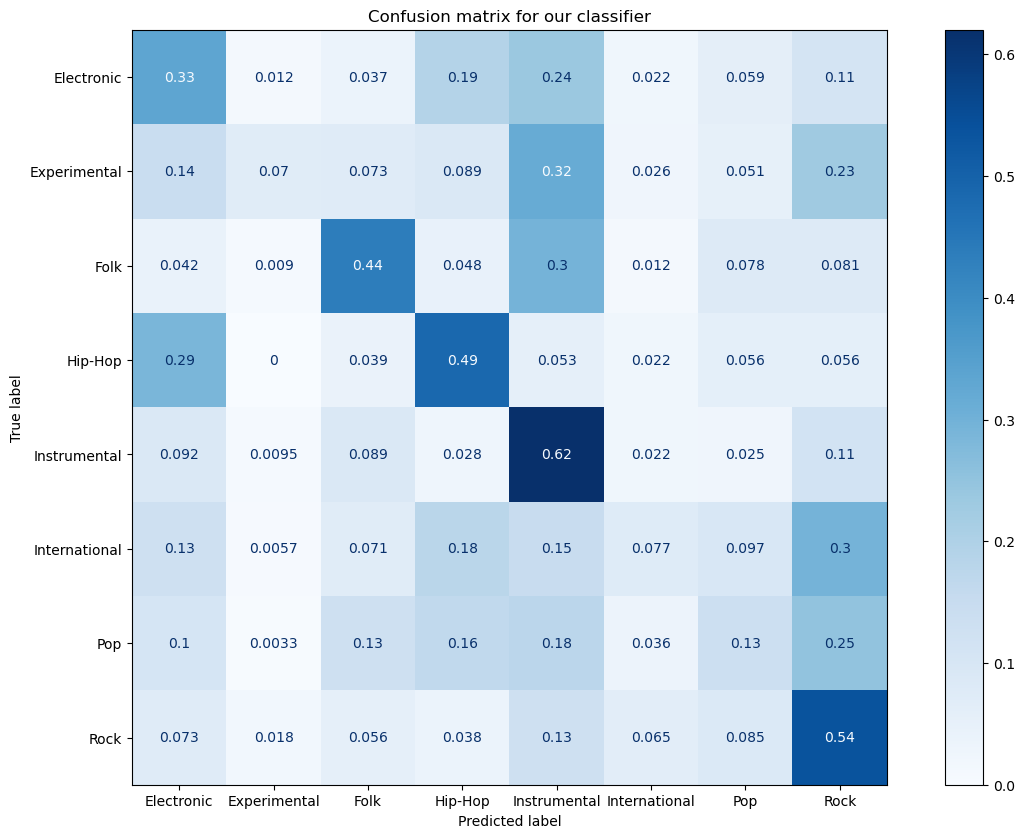

               precision    recall  f1-score   support

   Electronic       0.27      0.33      0.30       321
 Experimental       0.54      0.07      0.12       313
         Folk       0.48      0.44      0.45       335
      Hip-Hop       0.42      0.49      0.45       356
 Instrumental       0.31      0.62      0.41       316
International       0.29      0.08      0.12       352
          Pop       0.21      0.13      0.16       306
         Rock       0.33      0.54      0.41       341

     accuracy                           0.34      2640
    macro avg       0.35      0.34      0.30      2640
 weighted avg       0.36      0.34      0.31      2640

Accuracy:  0.3390151515151515


In [8]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Predict the test set
predictions = clf.predict(X_test)
# Generate confusion matrix
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)

print(classification_report(y_test, predictions))

print("Accuracy: ", accuracy_score(y_test, predictions))